# Lab 3: Mapping with Fully-Connected Networks
Blocks of dense layers are really good at memorizing patterns.
This week we'll step outside the traditional "prediction" regime of machine learning and use a fully-connected network (FCN) to represent a 2-D scene in its weight by interpolating between known points.

Throughout, you should be impressed by two (related) properties of dense neural nets:
 - They have high enough capacity to entirely memorize complex patterns
 - They are sufficiently nonlinear to build these patterns up from simple inputs (like (x, y) coordinates in this case)

In [24]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

# Pointcloud mapping

![full scene](./images/full_scene.png)

### The problem
Imagine there is a square (2-D) room with four walls and several square and circular objects in it.
We put laser distance sensors around the room, which shoot rays that continue until they hit an object or a wall and report the distance, with limited angular and radial resolution.
We want to use this limited data to produce a full 2-D reconstruction of the scene, filling in points the sensors haven't observed with likely values (in essence, interpolating).

### The data
We know that every ray that there's an object at the point each ray hit, and we also know that there's no object between the camera and the contact point.
The data is provided as (x, y) pairs, where some points correspond to places we know are on object boundaries (shown in green above) and points we know are not inside objects (shown in red above).

These points come in two data files: `data/positives.txt` for points on the edge of objects, and `data/negatives.txt` for points outside of objects.
To generate these files, run `make_data.py`.

(Check out the code if you want to see how the points are generated, but don't change anything!)

### The model
We want to store a full description of the scene in the weights of a neural network.
To do this, we'll train a FCN to classify (x, y) points by whether or not they are the edge of a wall or object.
Then, we can draw the scene by sampling (x, y) pairs and drawing the model's output.
So, the network has "memorized" where the objects and walls are, and what their shapes are.

# Section 1: Load the data
Load the data using `np.loadtxt()` (default arguments should work), then convert it to a usable format with a feature array and label array, which is 1 if a point is the edge of an object and 0 if it is not.

Functions to look at:
 - `np.loadtxt`
 - `np.concatenate`

In [ ]:
# Your code here

# Load the data from the text files
positive_data = np.loadtxt(r'data/positives.txt')  # Each line should be a coordinate (x, y)
negative_data = np.loadtxt(r'data/negatives.txt')  # Same format for negative data

# Create feature arrays (coordinates)
positive_features = positive_data  # Shape: (n_positive, 2) where each row is (x, y)
negative_features = negative_data  # Shape: (n_negative, 2)

# Create label arrays (1 for positive, 0 for negative)
positive_labels = np.ones(positive_features.shape[0])  # Label 1 for positive data
negative_labels = np.zeros(negative_features.shape[0])  # Label 0 for negative data

# Combine the positive and negative data into a single dataset
features = np.concatenate((positive_features, negative_features), axis=0)
labels = np.concatenate((positive_labels, negative_labels), axis=0)

# Now, `features` contains all the coordinates and `labels` contains the corresponding labels


# Section 2: Build a data pipeline
Set up a `tf.data.Dataset` and a `tf.summary.SummaryWriter`.
This time, there's no test set, just a single dataset. You may want to use the `repeat` method on the dataset for the number of desired epochs. If so, call it after caching so as not to store redundant data.

In [ ]:
# Assume features and labels are already created as NumPy arrays
# features: shape (N, 2), labels: shape (N,)

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

# Shuffle, cache, and batch the dataset
batch_size = 32
dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data
dataset = dataset.batch(batch_size)          # Batch the data
dataset = dataset.cache()  
dataset = dataset.repeat(3)

# Set up the TensorBoard SummaryWriter
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)

# Optionally, log some sample data (e.g., first batch)
for batch_features, batch_labels in dataset.take(1):
    with summary_writer.as_default():
        tf.summary.scalar("batch_sample_label", batch_labels[0], step=0)
        tf.summary.histogram("batch_features", batch_features, step=0)

# Section 3: Build a model graph
The model is a simple fully-connected neural network with four hidden layers, each with 64 units, and an output layer that performs binary classification with sigmoid activation.
Recall that the input is just a pair (x, y).

Functions to look at throughout:
 - `tf.cast`
 - `tf.expand_dims`
 - `tf.squeeze`
 - arithmetic operations

### 3.1: Class to make dense layers
It's tedious (and bad design) to explicitly write out every variable, matrix multiplication, etc.
Instead, it's common to define classes that create one of a structure you expect to repeat in your model.

Write a `tf.Module` class called `Dense`, which has its signature and scopes defined as a stub below.
When called, it should add variables and operations to the graph which implement a single dense layer.

If `do_activation` is True, it should apply ReLU activation to the computed values.
To do this, you can use `tf.nn.relu`.

In [ ]:
class Dense(tf.Module):
    '''
    Creates a dense layer module.

    Parameters
    ----------
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name scopes in this layer.
    name: string
        Name of layer.
    '''
    def __init__(self, dim_input, dim_output, do_activation=True, postfix='', name=None):
        super().__init__(name=name)
        self.do_activation = do_activation
        self.dim_input = dim_input
        self.dim_output = dim_output

        with tf.name_scope('dense' + postfix):
            # Weight matrix shape: [input_dim, output_dim]

            self.w = tf.Variable(
                tf.initializers.he_uniform()(shape=(dim_input, dim_output)),
                name='weights',
                dtype=tf.float64
            )
            # Bias vector shape: [output_dim]
            self.b = tf.Variable(
                tf.zeros([dim_output]),
                name='bias',
                dtype = tf.float64
            )

    def __call__(self, x):
        z = tf.matmul(x, self.w) + self.b
        if self.do_activation:
            return tf.nn.relu(z)
        return z

### 3.2: Class to make neural network
Use the `Dense` class to make four dense layers contained as fields in a `tf.Module` class called `FeedForward`.
Each should have 64 units, the correct input dimensions, and a distinct (and meaningful) postfix.

#### 3.2.1: Compute logit
Use the `Dense` class to make a final dense layer with `dim_output=1` to compute the final logit. You'll want to put this in a method called `logits` which should take in `self` and an input.

#### 3.2.2: Compute class probability for output
Use `tf.sigmoid` to compute the probability that the input coordinate is a boundary point.
We will not use this for the loss, just for the output. You'll want to put this in the `__call__` method.

In [ ]:
class FeedForward(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.dense1 = Dense(dim_input=2, dim_output=64, do_activation=True, postfix='_1')
        self.dense2 = Dense(dim_input=64, dim_output=64, do_activation=True, postfix='_2')
        self.dense3 = Dense(dim_input=64, dim_output=64, do_activation=True, postfix='_3')
        self.dense4 = Dense(dim_input=64, dim_output=64, do_activation=True, postfix='_4')
        # Output layer without activation (logit)
        self.output_layer = Dense(dim_input=64, dim_output=1, do_activation=False, postfix='_out')

    def logits(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.output_layer(x)

    def __call__(self, x):
        # Get logits and pass through sigmoid to get probabilities
        logit = self.logits(x)
        return tf.sigmoid(logit)
    
    def _loss(self, x, y):
        # Ensure labels are the right shape (batch_size, 1)
        # y = tf.cast(tf.expand_dims(y, axis=1), tf.float32)
        logit = self.logits(x)

        loss_per_example = tf.nn.weighted_cross_entropy_with_logits(
            labels=y,
            logits=logit,
            pos_weight=20.0  
        )

        # reduce mean
        return tf.reduce_mean(loss_per_example)


### 3.3: Compute weighted cross-entropy loss
There are about 33 times as many non-boundary coordinates as there are boundary coordinates.
To prevent the network from just learning to predict that every coordinate is not a boundary, we should weight the loss function to consider boundary pixels more heavily.

To do this, use `tf.nn.weighted_cross_entropy_with_logits()` on the logits computed before, plus the input label, and a positive weight of 20.
Then, produce the mean loss for the batch with `tf.reduce_mean`. Put this in a `_loss` method.

### 3.4: Optimizer and gradients
Make an optimizer (I used `tf.optimizers.SGD` with `learning_rate=2e-3` and `momentum=0.9`).
Then write a train method (taking in a model, input, output, and step), that represents one step of training, where you explicitly compute the gradients in a variable called `gradients` (so we can plot them below) and make an operation that applies those gradients to the graph.

Note: don't use `optimizer.minimize`, which will result in computing the gradients twice since we already have them from `GradientTape.gradient`. Add a summary scalar to plot loss in TensorBoard.

In [29]:
# Your code here
optimizer = tf.optimizers.SGD(learning_rate=2e-3, momentum=0.9)


def train_step(model, x, y, step, summary_writer):
    with tf.GradientTape() as tape:
        loss = model._loss(x, y)
    
    # Compute gradients with respect to trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log the loss to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', loss, step=step)
        for gradient, variable in zip(gradients, model.trainable_variables):
            if variable.name and gradient is not None:
                tf.summary.histogram('gradients/' + variable.name, tf.norm(gradient), step=step)
                tf.summary.histogram('variables/' + variable.name, tf.norm(variable), step=step)
    return loss, gradients


#### 3.4.1: Plot variables and gradients
You don't need to do this for every model, but it's illustrative to do at least once. I've written the code for this below, with a pattern borrowed from http://matpalm.com/blog/viz_gradient_norms/. Put this code snippet under the same `with` block where you add your loss summary scalar.

```
for gradient, variable in zip(gradients, model.trainable_variables):
    if variable.name and gradient is not None:
        tf.summary.histogram('gradients/' + variable.name, tf.norm(gradient), step=i)
        tf.summary.histogram('variables/' + variable.name, tf.norm(variable), step=i)
```

In [30]:
# Your code here

# Section 4: train the model
Same as last time, except there's no test set.
You don't need to distinguish between epochs and steps here.

I used 50 epochs, and got a final cross-entropy loss of about 0.4.
You might not need to use this many epochs to get reasonable results, but more will get crisper results.

This might take a while on CPUs, so if it's taking too long, think about:
 - Using Google Colaboratory
 - Increasing your batch size
 - Reducing the frequency with which you run summary ops
 
Watching plots, histograms, etc in TensorBoard as the model trains can be fun.

In [31]:
# Your code here

# Instantiate model and summary writer
model = FeedForward()
summary_writer = tf.summary.create_file_writer("logs/train")


step = 0
for i in range(1): #50 epochs
    print(f"epoch {i}:")
    for batch_features, batch_labels in dataset:
        loss, gradients = train_step(model, batch_features, batch_labels, step, summary_writer)

        # Optionally print progress
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy():.4f}")

        step += 1


epoch 0:
Step 0, Loss: 11.3969
Step 100, Loss: 1.5287
Step 200, Loss: 0.4172
Step 300, Loss: 0.0518
Step 400, Loss: 0.0203
Step 500, Loss: 0.0111
Step 600, Loss: 0.0052
Step 700, Loss: 0.0031
Step 800, Loss: 0.0028
Step 900, Loss: 9.6438
Step 1000, Loss: 1.7763
Step 1100, Loss: 0.7214
Step 1200, Loss: 0.2398
Step 1300, Loss: 0.0836
Step 1400, Loss: 0.0370
Step 1500, Loss: 0.0225
Step 1600, Loss: 0.0151
Step 1700, Loss: 0.0107
Step 1800, Loss: 4.8233
Step 1900, Loss: 1.2635
Step 2000, Loss: 0.3208
Step 2100, Loss: 0.0818
Step 2200, Loss: 0.0364
Step 2300, Loss: 0.0213
Step 2400, Loss: 0.0141
Step 2500, Loss: 0.0103
Step 2600, Loss: 0.0080
Step 2700, Loss: 2.1886
Step 2800, Loss: 1.3006
Step 2900, Loss: 0.3769
Step 3000, Loss: 0.1055
Step 3100, Loss: 0.0469
Step 3200, Loss: 0.0270
Step 3300, Loss: 0.0182
Step 3400, Loss: 0.0134
Step 3500, Loss: 0.0104
Step 3600, Loss: 2.2743
Step 3700, Loss: 1.4763
Step 3800, Loss: 0.6105
Step 3900, Loss: 0.2440
Step 4000, Loss: 0.1129
Step 4100, Loss: 0

# Section 5: Plot the model
Let's see what the network learned.
Generate 100 x values and 100 y values, each in the range (-1, 1).
Then compute the value of `probability` (the sigmoid output of your model) using every coordinate in that grid (every pairwise combination of x and y values), and plot a "map" of those probabilities using `plt.scatter()` (check out the `c` argument).

In [32]:
test = [[9.899889883644900079e-01, 2.993364156690488387e-01], [-1.015288177056490326e+00, -4.436604427019936736e-01]]

prob = model(test)

print(prob)
print(test)
predicted_labels = tf.cast(prob > 0.5, tf.float32)
print(predicted_labels)

tf.Tensor(
[[0.01871433]
 [0.01871685]], shape=(2, 1), dtype=float32)
[[0.98998898836449, 0.29933641566904884], [-1.0152881770564903, -0.4436604427019937]]
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


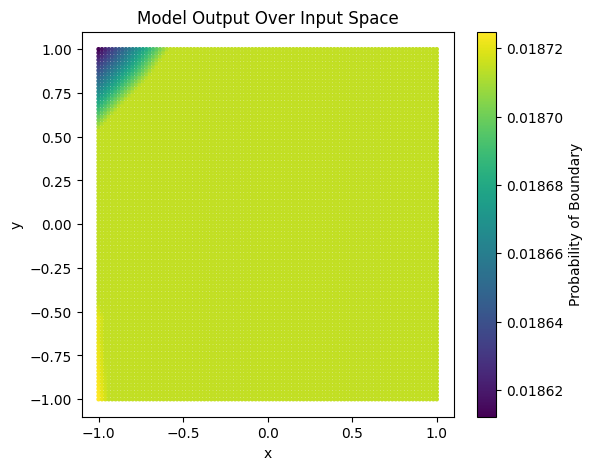

In [33]:
# Your code here

# 1. Generate a grid of 100 x and 100 y values between -1 and 1
x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)

# 2. Create all pairwise (x, y) combinations using meshgrid and reshape
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)

# 3. Convert to float32 tensor for model input
grid_tensor = tf.convert_to_tensor(grid_points, dtype=tf.float32)

# 4. Compute predicted probabilities from the model
probs = model(grid_tensor)  # or model.__call__(grid_tensor)
probs = tf.squeeze(probs).numpy()  # Remove singleton dimension and convert to NumPy


# 5. Plot using plt.scatter with colors corresponding to probabilities
plt.figure(figsize=(6, 5))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=probs, cmap='viridis', s=5)
plt.colorbar(label='Probability of Boundary')
plt.title("Model Output Over Input Space")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Section 6: TensorBoard plots
This time, we have some more interesting TensorBoard plots than last time.
Run TensorBoard, and look at:
 - The loss over time in Scalars
 - The weights, biases, and gradients over time in Distributions and Histograms
 
The loss should decrease over time, and eventually stabilize (with some noise).

The gradients for weights and biases may not go to zero, and your weights and biases may not look like they're converging.
This is because of "bias drift" where multiple possible settings of weights and biases have the same loss value.
To fix this, we could add a term to the loss which penalizes the model slightly based on the magnitude of the bias terms.

# Section 7: Again, but in Keras
Make a Keras Sequential model which is equivalent to the one we've trained in TensorFlow.
Train it on the same dataset, and again plot its output in the same way. 

Hints:
 - This won't take nearly as long as the previous sections
 - You don't need to use `keras.utils.to_categorical` since this is binary classification.
 - The appropriate loss function is 'binary_crossentropy'
 - To implement the same loss weighting, use `class_weight={0: 1.0, 1:20.0}` in `model.fit()`
 - You can get the outputs of the model over the entire grid at once with `model.predict()`

### 7.1: Build a model
Use `keras.models.Sequential` to build the same FCN as before.

In [34]:
# Your code here

### 7.2: Define an optimizer and compile the model

In [35]:
# Your code here

### 7.3: Fit the model

In [36]:
# Your code here

### 7.4: Plot the model

In [37]:
# Your code here